# Warning :

# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


Avant de commencer le TP, vérifiez que vous êtes sur un environnement GPU et python 3 :

Exécution -> Modifier le type d'exécution -> Type d'exécution = python2, Accélerateur matériel = GPU


In [4]:
import argparse
import os
import time
from icecream import ic

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Partie 1 : Architecture VGG16


## Question 3 : Bonus

In [5]:
# !wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
# !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
# !wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
# !wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

From the pytorch doc, the vgg input has to be (C, H, W)

> The inference transforms are available at VGG16_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].


In [45]:
torchvision.models.VGG16_Weights.IMAGENET1K_V1.transforms()

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


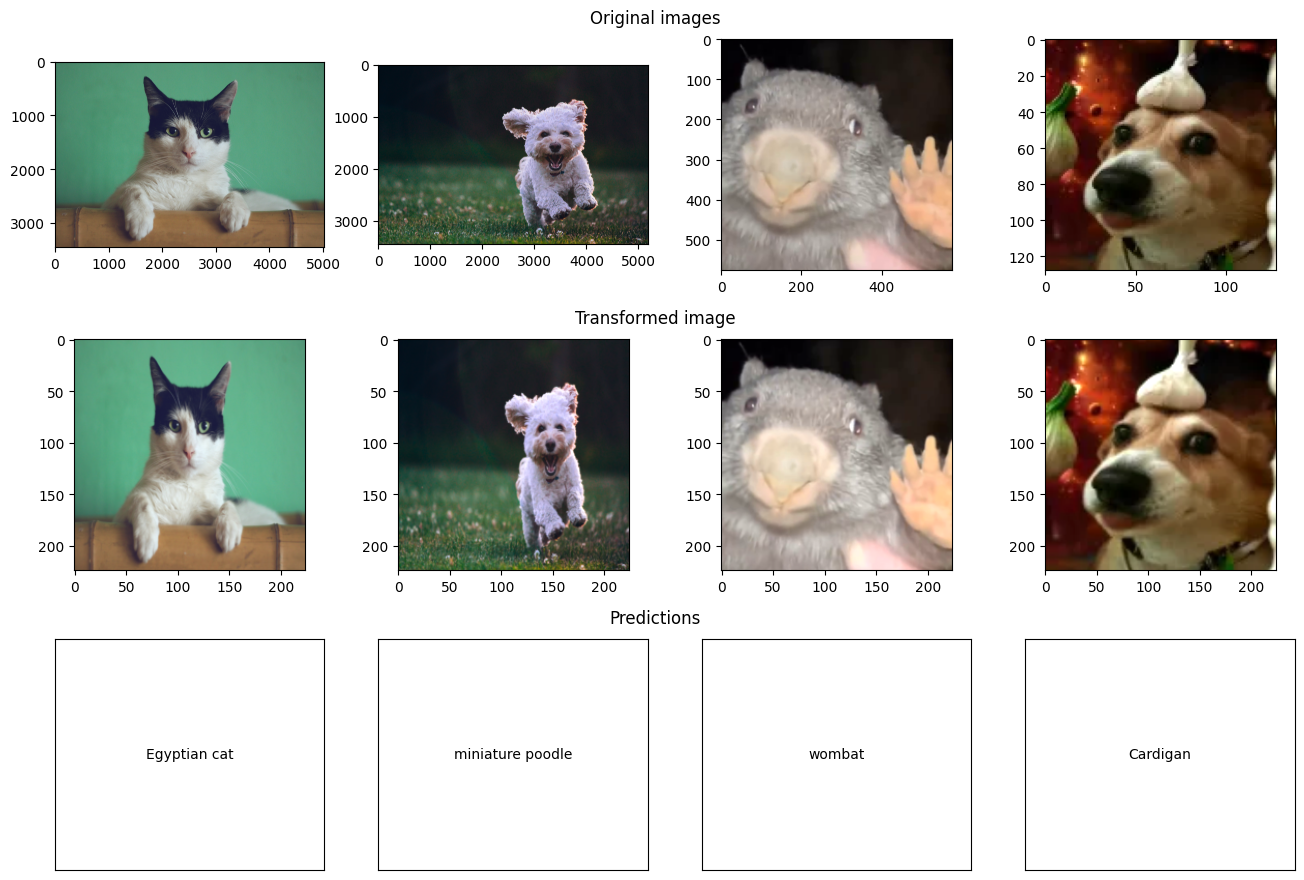

In [66]:
dog_meme = Image.open("kadaver-vanilla.webp")
bobr = Image.open("bobr.png").convert("RGB")  # 4 channels here
dog = Image.open("dog.jpg")
cat = Image.open("cat.jpg")

vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
vgg16.eval()
imagenet_classes = pickle.load(
    open("imagenet_classes.pkl", "rb")
)  # chargement du nom des classes


def print_min_max(img):
    img2 = np.array(img)
    print("Min: %.3f, Max: %.3f" % (img2.min(), img2.max()))
    print(img2.shape)
    return img


def manual_norm(img):
    m = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return (img - m) / std


model_transform_pipeline = torchvision.models.VGG16_Weights.IMAGENET1K_V1.transforms()
to_view_transform_pipeline = transforms.Compose(
    # let's reporduce the model transformation here
    [
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.Resize((226, 226), interpolation=Image.BILINEAR),
        transforms.CenterCrop(224),
        transforms.Lambda(lambda img: np.array(img) / 225.0),
    ]
)


fig = plt.figure(figsize=(16,9))
# fig.suptitle('')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
axs = subfigs[0].subplots(nrows=1, ncols=4)
subfigs[0].suptitle("Original images")
for ax, img in zip(axs, [cat, dog, bobr, dog_meme]):
    ax.imshow(img)

axs = subfigs[1].subplots(nrows=1, ncols=4)
subfigs[1].suptitle("Transformed image")
for ax, img in zip(axs, [cat, dog, bobr, dog_meme]):
    ax.imshow(to_view_transform_pipeline(img))

axs = subfigs[2].subplots(nrows=1, ncols=4)
subfigs[2].suptitle("Predictions")
for ax, img in zip(axs, [cat, dog, bobr, dog_meme]):
    x = model_transform_pipeline(img).unsqueeze(0)  # to batch
    y_hat = vgg16(x)
    idx = y_hat.argmax()
    txt = imagenet_classes[idx.item()].split(',')[0] # if multiple classes 
    ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis="y", which="both", right=False, left=False, labelleft=False)
    ax.text(0.5, 0.5, txt, horizontalalignment="center", verticalalignment="center")
# fig.savefig('')

## Question 4: Bonus

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene


In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
# !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

In [29]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [77]:
def get_dataset(batch_size, path, transform=None, ):
    def duplicateChannel(img):
        img = img.convert("RGB")
        # np_img = np.array(img, dtype=np.uint8)
        # np_img = np.dstack([np_img, np_img, np_img])
        # img = Image.fromarray(np_img, 'RGB')
        return img

    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda
    if not transform:
        transform = transforms.Compose(
            [  # Pré-traitement à faire
                transforms.Resize((224, 224), interpolation=Image.NEAREST),
                transforms.Lambda(duplicateChannel),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        ),

    train_dataset = datasets.ImageFolder(
        path + "/train",
        transform=transform
    )

    val_dataset = datasets.ImageFolder(
        path + "/test",

        transform=transform
    )
    
    CUDA = torch.cuda.is_available()
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=CUDA,
        num_workers=2,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=CUDA,
        num_workers=2,
    )

    return train_loader, val_loader

class VGG16relu17(nn.Module):
    def __init__(self, vgg16):
        super().__init__()
        self.features = vgg16.features[:-1]
        self.avgpool = vgg16.avgpool
        self.classifier = vgg16.classifier[:-2]

    def forward(self, x):
        # ic(x.size())
        x = self.features(x)
        x = self.avgpool(x)
        # ic(x.size())
        x = x.view(x.size(0), -1)
        # ic(x.size())
        x = self.classifier(x)
        return x

PRINT_INTERVAL = 50
def extract_features(data, model, device):
    X = torch.tensor([], device=device)
    y = torch.tensor([])

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print("Batch {0:03d}/{1:03d}".format(i, len(data)))
        input = input.to(device)
        X = torch.cat((X, model(input)))
        y = torch.cat((y, target))

    return torch.tensor(X), torch.tensor(y)


def main(path="15SceneData", batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Instanciation de VGG16")
    w = torchvision.models.VGG16_Weights.IMAGENET1K_V1
    model_transform_pipeline = w.transforms()
    vgg16 = torchvision.models.vgg16(weights=w)

    print("Instanciation de VGG16relu7")
    model = VGG16relu17(vgg16)
    model.eval()
    model.to(device)

    # On récupère les données
    print("Récupération des données")
    train, test = get_dataset(batch_size, path, transform=model_transform_pipeline)

    # Extraction des features
    print("Feature extraction")
    X_train, y_train = extract_features(train, model, device=device)
    X_test, y_test = extract_features(test, model, device=device)

    # Apprentissage et évaluation des SVM à faire
    print("Apprentissage des SVM")
    svm = LinearSVC(C=1.0).fit(X_train, y_train)
    accuracy = accuracy_score(y_test, svm.predict(X_test))
    print("Accuracy = %f" % accuracy)

main("15SceneData", 8)

Instanciation de VGG16
Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188


RuntimeError: handle_0 INTERNAL ASSERT FAILED at "../c10/cuda/driver_api.cpp":15, please report a bug to PyTorch. 